### Imports and Downloads

In [ ]:
%pip install yfinance
%pip install pandas_datareader

In [2]:
#Checking python version
import sys
print(sys.version)

3.9.16 (main, Jan 11 2023, 16:16:36) [MSC v.1916 64 bit (AMD64)]


### Import data from yahoo.finance

In [3]:
import math
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
yf.pdr_override()
%matplotlib inline

In [4]:
TICKER = 'NVDA'
start_date = '2016-01-01'
end_date = '2023-06-07'
stock = pdr.get_data_yahoo(TICKER, start=start_date, end=end_date)
stock = stock.drop(['High', 'Open','Low', 'Adj Close', 'Volume'], axis=1)
stock.tail()

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2023-05-31,378.339996
2023-06-01,397.700012
2023-06-02,393.269989
2023-06-05,391.709991
2023-06-06,386.540009


### Find MA50 and MA200

In [5]:
stock['MA_50'] = stock.Close.rolling(50).mean()
stock['MA_200'] = stock.Close.rolling(200).mean()
stock = stock.dropna() #Remove NaN row
stock.head()

,Close,MA_50,MA_200
Date,,,
2016-10-17,16.402500,15.88255,11.271262
2016-10-18,16.652500,15.92190,11.314062
2016-10-19,16.617500,15.95980,11.356037
2016-10-20,16.932501,16.00590,11.401288
2016-10-21,16.885000,16.04510,11.447863


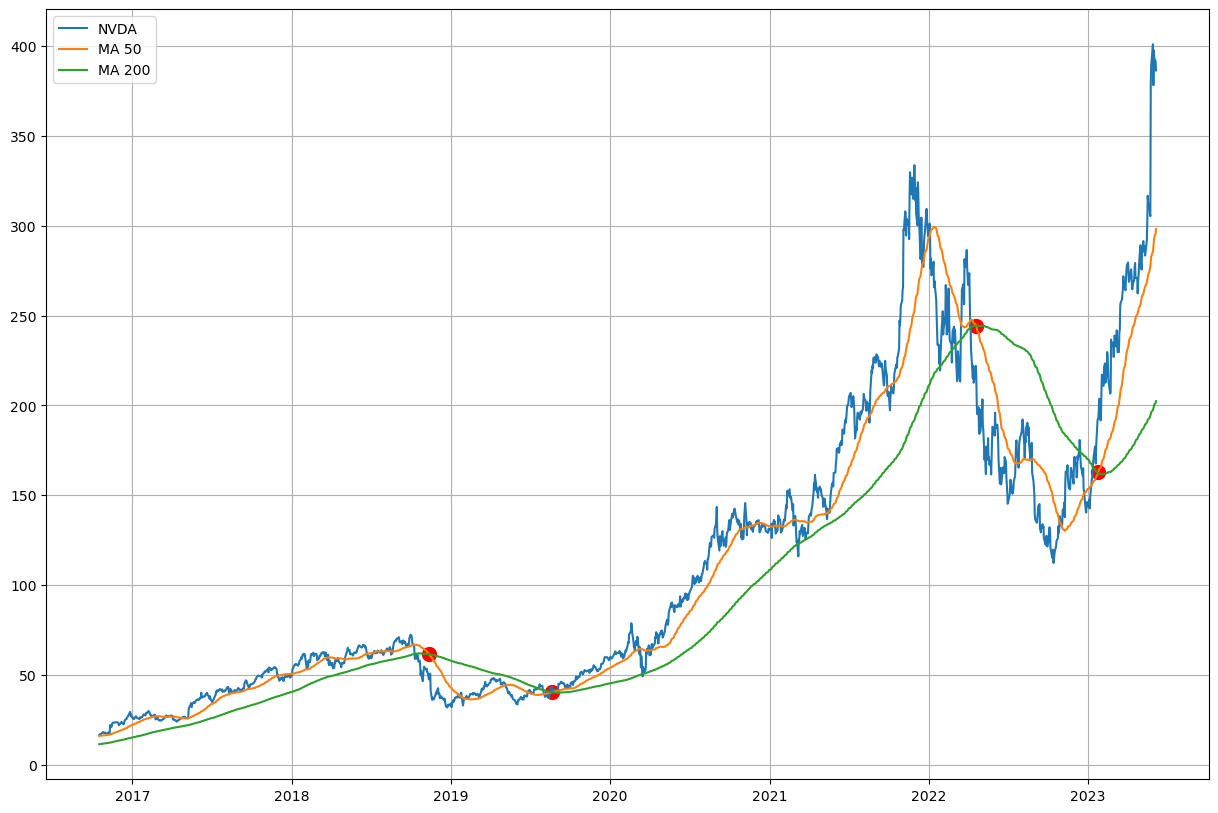

In [9]:
plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(stock['Close'], label=TICKER)
plt.plot(stock['MA_50'], label='MA 50')
plt.plot(stock['MA_200'], label='MA 200')

sign_diff = np.sign(stock['MA_50'] - stock['MA_200'])
idx = np.concatenate((np.argwhere(np.diff(sign_diff) > 0).flatten(), np.argwhere(np.diff(sign_diff) < 0).flatten()))

plt.scatter(stock.index[idx], stock['MA_200'][idx], color='red', s = 100)
plt.legend(loc=2)

### Strategy Backtesting

In [6]:
#Buy and hold return
INIT_BALANCE = 1000
stock['Return_0'] = stock['Close'].pct_change().fillna(0)
#cumprod() calculates the cumulative product of values in a DataFrame
stock['Balance_0'] = (1 + stock['Return_0']).cumprod() * INIT_BALANCE
# Returns
print(f"Daily volatility: {np.std(stock['Return_0'])*100:.2f}%" )
print(f"Overall Buy-and-Hold return: {(stock['Balance_0'][-1] / stock['Balance_0'][0] -1) *100:.2f}%")
stock.head()

Daily volatility: 3.28%
Overall Buy-and-Hold return: 2256.59%


,Close,MA_50,MA_200,Return_0,Balance_0
Date,,,,,
2016-10-17,16.402500,15.88255,11.271262,0.000000,1000.000000
2016-10-18,16.652500,15.92190,11.314062,0.015242,1015.241579
2016-10-19,16.617500,15.95980,11.356037,-0.002102,1013.107767
2016-10-20,16.932501,16.00590,11.401288,0.018956,1032.312189
2016-10-21,16.885000,16.04510,11.447863,-0.002805,1029.416252


In [7]:
#Trading return

#Golden Cross -> 50MA goes above 200MA -> Buy
#Death Cross -> 50MA goes below 200MA -> Sell
#Strategy: if 50MA > 200MA -> Buy, else Sell, golden and death cross will be buy/sell point

stock['Long'] = stock['MA_50'] > stock['MA_200']

stock['Return_1'] = np.where(stock['Long'].shift(1) == True, stock['Return_0'], 0)
stock['Balance_1'] = (1 + stock['Return_1']).cumprod() * INIT_BALANCE
# Returns
print(f"Overall Trading return: {(stock['Balance_1'][-1] / stock['Balance_1'][0] -1) *100:.2f}%")
stock.head()

Overall Trading return: 2954.26%


,Close,MA_50,MA_200,Return_0,Balance_0,Long,Return_1,Balance_1
Date,,,,,,,,
2016-10-17,16.402500,15.88255,11.271262,0.000000,1000.000000,True,0.000000,1000.000000
2016-10-18,16.652500,15.92190,11.314062,0.015242,1015.241579,True,0.015242,1015.241579
2016-10-19,16.617500,15.95980,11.356037,-0.002102,1013.107767,True,-0.002102,1013.107767
2016-10-20,16.932501,16.00590,11.401288,0.018956,1032.312189,True,0.018956,1032.312189
2016-10-21,16.885000,16.04510,11.447863,-0.002805,1029.416252,True,-0.002805,1029.416252


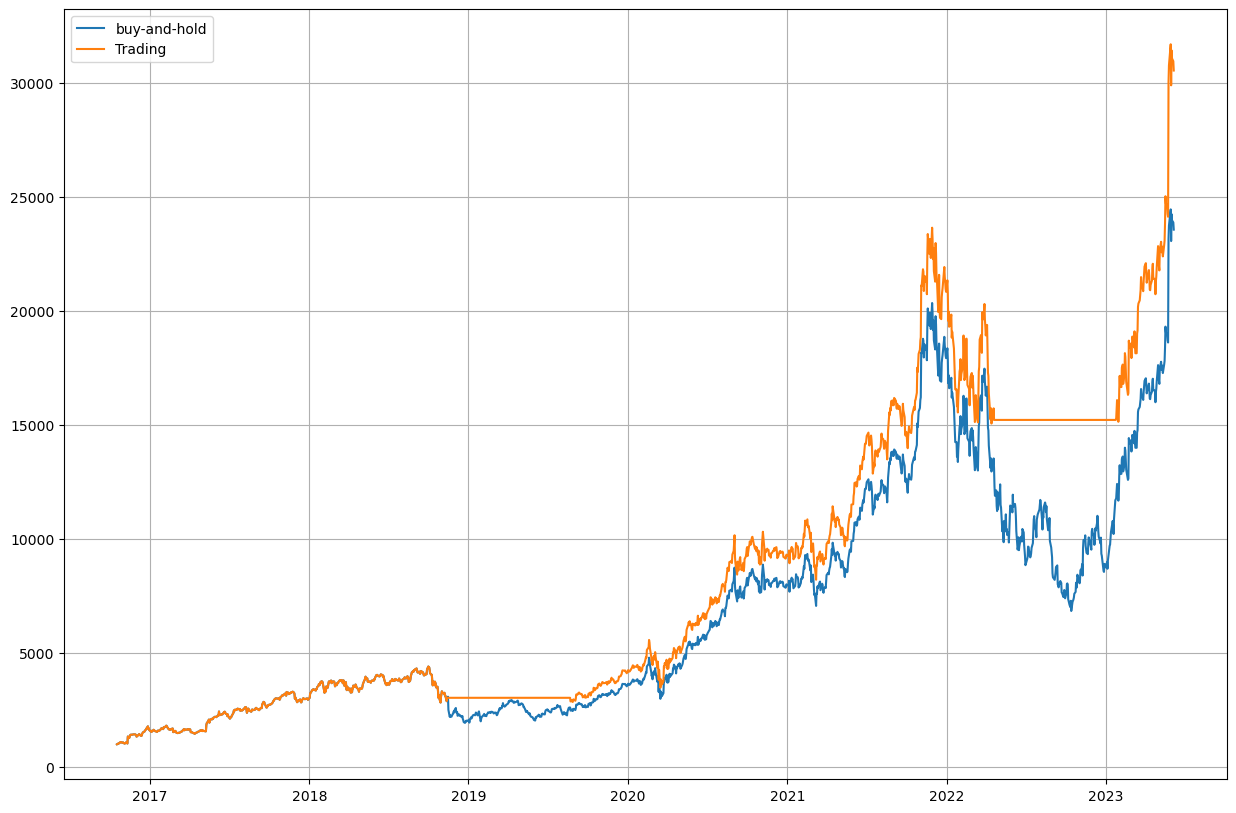

In [8]:
plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(stock['Balance_0'], label='buy-and-hold')
plt.plot(stock['Balance_1'], label='Trading')
plt.legend(loc=2)
plt.show()

## Improvement

### Import and download

In [ ]:
%pip install backtesting
%conda install -c conda-forge ta-lib

In [ ]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)
#Restart kernal to solve dependency conflicts

In [13]:
import talib
from backtesting.lib import crossover
from backtesting.lib import plot_heatmaps
from backtesting import Backtest, Strategy
from datetime import datetime
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()

### Creating strategy object

In [2]:
class SMAcross(Strategy):

  ma_fast = 50
  ma_slow = 200

  def init(self):
    close = self.data.Close
    self.buy()
    self.ma_0 = self.I(talib.SMA, self.data.Close, self.ma_fast)
    self.ma_1 = self.I(talib.SMA, self.data.Close, self.ma_slow)

  def next(self):
    if crossover(self.ma_0, self.ma_1):
      # self.position.close()
      self.buy()
    elif crossover(self.ma_1, self.ma_0):
      self.position.close()
      # self.sell()

### Data fetching and running the strategy

In [3]:
TICKER = 'NVDA'
start_date = '2016-01-01'
end_date = '2023-06-07'
data = pdr.get_data_yahoo(TICKER, start=start_date, end=end_date)

bt = Backtest(data, SMAcross, cash = 1000)

#Optimization by grid search
stats, heatmap = bt.optimize(
    ma_fast = range(10,55,5),
    ma_slow = range(100,305,5),
    maximize = 'Return [%]',
    return_heatmap = True,
)

[*********************100%***********************]  1 of 1 completed


c:\Users\Love\anaconda3\lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 369 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

### Summary statistic

In [4]:
print(stats)
bt.plot()
plot_heatmaps(heatmap)
print(f'Optimized fast MA: {stats["_strategy"].ma_fast}')
print(f'Optimized slow MA: {stats["_strategy"].ma_slow}')

Start                     2016-01-04 00:00:00
End                       2023-06-06 00:00:00
Duration                   2710 days 00:00:00
Exposure Time [%]                   73.729267
Equity Final [$]                 55601.916367
Equity Peak [$]                  57433.746017
Return [%]                        5470.845898
Buy & Hold Return [%]             4676.521734
Return (Ann.) [%]                   71.951155
Volatility (Ann.) [%]               74.203126
Sharpe Ratio                         0.969651
Sortino Ratio                         2.86054
Calmar Ratio                         1.491779
Max. Drawdown [%]                  -48.231792
Avg. Drawdown [%]                   -5.759729
Max. Drawdown Duration      499 days 00:00:00
Avg. Drawdown Duration       25 days 00:00:00
# Trades                                    4
Win Rate [%]                             75.0
Best Trade [%]                      405.69593
Worst Trade [%]                     -8.991661
Avg. Trade [%]                    

### Computing Buy and Hold return

In [18]:
'''
Since the first trade for MA strategy starts on 2016-07-01 
calculate true Buy-and-Hold return from 2016-07-01 to 2016-06-06.
'''
start_date = datetime.strftime(stats['_trades'].EntryTime[0], '%Y-%m-%d')
end_date = '2023-06-06'

print(f'{start_date} close price: {data.loc[start_date].Close}')
print(f'{end_date} close price: {data.loc[end_date].Close}')
print(f'Buy and Hold return: {(data.loc[end_date].Close/data.loc[start_date].Close -1)*100}%')

2016-07-01 close price: 11.664999961853027
2023-06-06 close price: 386.5400085449219
Buy and Hold return: 3213.673466000754%


### Testing on the overall market index S&P 500 (SPY)

In [19]:
TICKER = 'SPY'
start_date = '2016-01-01'
end_date = '2023-06-07'
data = pdr.get_data_yahoo(TICKER, start=start_date, end=end_date)

bt = Backtest(data, SMAcross, cash = 1000)

#Optimization by grid search
stats, heatmap = bt.optimize(
    ma_fast = range(10,90,5),
    ma_slow = range(100,305,5),
    maximize = 'Return [%]',
    return_heatmap = True,
)

print(stats)
bt.plot()
# plot_heatmaps(heatmap)
print(f'Optimized fast MA: {stats["_strategy"].ma_fast}')
print(f'Optimized slow MA: {stats["_strategy"].ma_slow}')

[*********************100%***********************]  1 of 1 completed


c:\Users\Love\anaconda3\lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 656 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

Start                     2016-01-04 00:00:00
End                       2023-06-06 00:00:00
Duration                   2710 days 00:00:00
Exposure Time [%]                   70.090958
Equity Final [$]                  1828.190033
Equity Peak [$]                   1926.680054
Return [%]                          84.464434
Buy & Hold Return [%]              112.929057
Return (Ann.) [%]                    8.605893
Volatility (Ann.) [%]               12.247086
Sharpe Ratio                         0.702689
Sortino Ratio                        1.034571
Calmar Ratio                         0.493856
Max. Drawdown [%]                  -17.425927
Avg. Drawdown [%]                   -1.295599
Max. Drawdown Duration      519 days 00:00:00
Avg. Drawdown Duration       22 days 00:00:00
# Trades                                    7
Win Rate [%]                        71.428571
Best Trade [%]                      45.268182
Worst Trade [%]                     -3.647306
Avg. Trade [%]                    

In [20]:
'''
Since the first trade for MA strategy starts on 2016-10-11 
calculate true Buy-and-Hold return from 2016-10-11 to 2016-06-06.
'''
start_date = datetime.strftime(stats['_trades'].EntryTime[0], '%Y-%m-%d')
end_date = '2023-06-06'

print(f'{start_date} close price: {data.loc[start_date].Close}')
print(f'{end_date} close price: {data.loc[end_date].Close}')
print(f'Buy and Hold return: {(data.loc[end_date].Close/data.loc[start_date].Close -1)*100}%')

2016-10-11 close price: 213.42999267578125
2023-06-06 close price: 428.0299987792969
Buy and Hold return: 100.54819541202522%
